# Feature Extraction for Vehicle Detection
A workbook which runs through the facets of 3 feature extraction techniques for object detection and tunes various parameters of all 3 on random images from the training data for the project

In [1]:
# imports. note that feature_extraction contains the 3 functions for feature extraction
import feature_extraction as fe
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from skimage import exposure
import random
import time
import pickle
%matplotlib inline

In [2]:
# the training data is stored in a central location defined below.
# Globbing reads multiple sub directories to build a list of image files
cars = glob.glob('../playground/exploration/vehicles/**/*.png', recursive=True)
notcars = glob.glob('../playground/exploration/non-vehicles/**/*.png', recursive=True)

print("There are {} car images and {} non car images in the training data".format(len(cars), len(notcars)))
print("The image shape - assuming all are equal - is {}".format(cv2.imread(cars[0]).shape))

There are 8792 car images and 8968 non car images in the training data
The image shape - assuming all are equal - is (64, 64, 3)


In [3]:
# the color list is used as a helper for image color conversion - it assumes images have been read into BGR (opencv default)
color_list = {
    'RGB': cv2.COLOR_BGR2RGB,
    'HSV': cv2.COLOR_BGR2HSV,
    'LUV': cv2.COLOR_BGR2LUV,
    'HLS': cv2.COLOR_BGR2HLS,
    'YUV': cv2.COLOR_BGR2YUV,
    'YCrCb': cv2.COLOR_BGR2YCrCb
}

## Explore Spatial Binning
The first technique is spatial binning which expects a 3 channel image. The function resizes the image to the size parameter, unfurls the pixels to a flattened list for each channel and then concatenates each channel to a single feature list.

The section below investigates 3 re-sizing parameters and the list of color spaces defined above for a vehicle and non-vehicle image

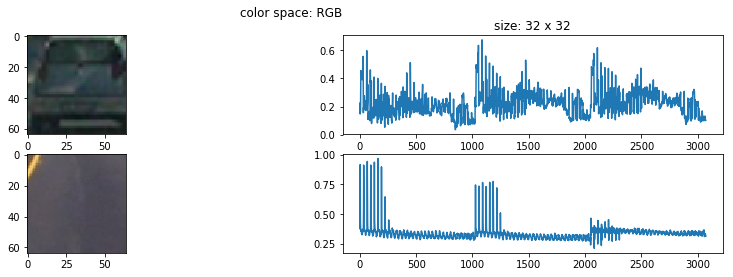

In [4]:
# let's look at 1 image with the default settings from each set using RGB
img_v = cv2.imread(cars[random.randrange(0,len(cars))])
img_v = img_v.astype(np.float32)/255
img_nv = cv2.imread(notcars[random.randrange(0,len(notcars))])
img_nv = img_nv.astype(np.float32)/255

img_pv = cv2.cvtColor(img_v, color_list['RGB'])
img_pnv = cv2.cvtColor(img_nv, color_list['RGB'])
feature_vec_v = fe.bin_spatial(img_pv)
feature_vec_nv = fe.bin_spatial(img_pnv)

# plot the images and the spatial bin results
fig, ax = plt.subplots(2,2,figsize=(15,4))
plt.suptitle("color space: {}".format('RGB'))
ax[0,0].imshow(img_pv)
ax[1,0].imshow(img_pnv)
ax[0,1].plot(feature_vec_v)
ax[0,1].set_title("size: {}".format('32 x 32'))
ax[1,1].plot(feature_vec_nv)

plt.show()

The results above show that there are differences in the histogram shape - and perhaps sufficient information in the histogram for the features to be useful input to a machine learning algorithm.

We should now look at various combinations of size and color space to see if, by eye, any specific combination looks better than another one

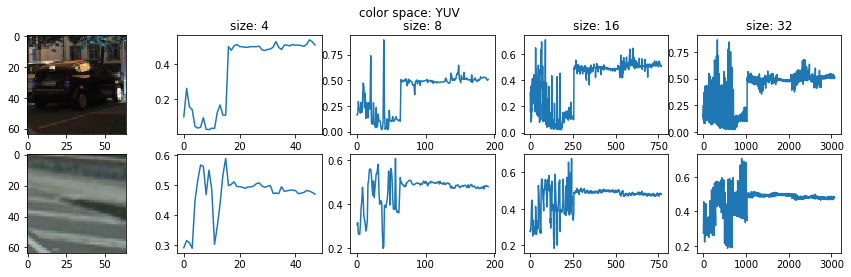

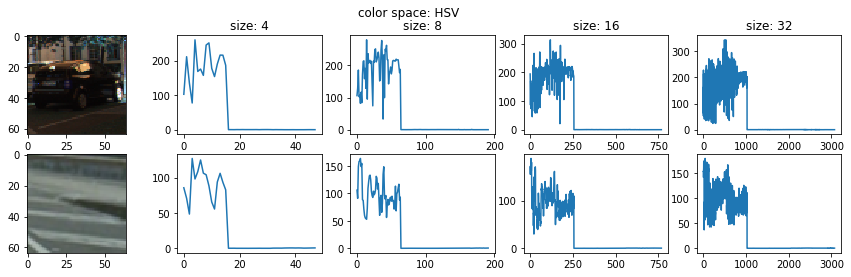

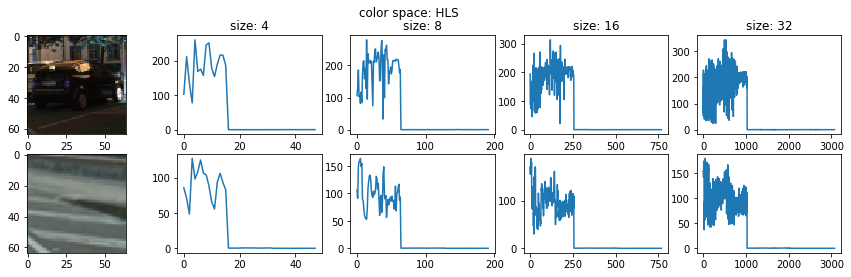

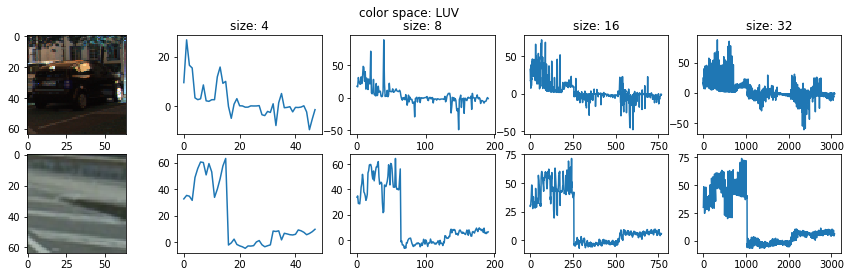

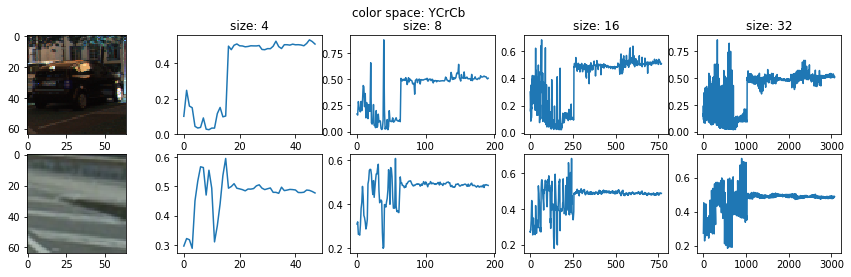

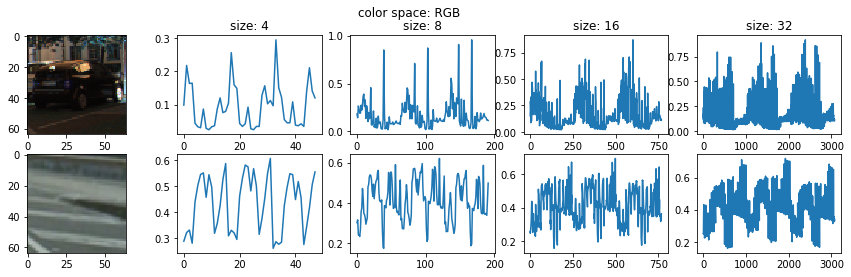

In [5]:
# select random vehicle and non-vehicle images and rescale to 0..1 will open as BGR
img_v = cv2.imread(cars[random.randrange(0,len(cars))])
img_v = img_v.astype(np.float32)/255
img_nv = cv2.imread(notcars[random.randrange(0,len(notcars))])
img_nv = img_nv.astype(np.float32)/255

# define the parameter list for size - the training data is 64x64
sizes = [4,8,16,32]

# cycle through the color_list and sizes list and show the various results...
for key in color_list:
    # create an output figure
    fig, ax = plt.subplots(2,len(sizes)+1,figsize=(15,4))
    plt.suptitle("color space: {}".format(key))
    c = 0
    # create an image copy for the color space
    img_pv = cv2.cvtColor(img_v, color_list[key])
    img_pnv = cv2.cvtColor(img_nv, color_list[key])
    ax[0,c].imshow(img_v)
    ax[1,c].imshow(img_nv)
    c += 1
    # cycle the sizes
    for size in sizes:
        feature_vec_v = fe.bin_spatial(img_pv, size=(size,size))
        feature_vec_nv = fe.bin_spatial(img_pnv, size=(size,size))
        ax[0,c].plot(feature_vec_v)
        ax[0,c].set_title("size: {}".format(size))
        ax[1,c].plot(feature_vec_nv)
        c += 1
plt.show()

By eye, for these 2 images, the Y channel of YCrCb and YUV and the H channel of HLS and HSV show significant differences in output. Size affects the shape of the historgram by encoded more values into the histogram (more bins).

## Explore the color histogram
The second technique is to get a histogram of each channel and to concatenate these together to obtain a flattened feature list. 

It's possible to tune the output using the color space and the number of bins. The bin range should reflect the extent of the pixel values - in the case of our training data this is 0..1

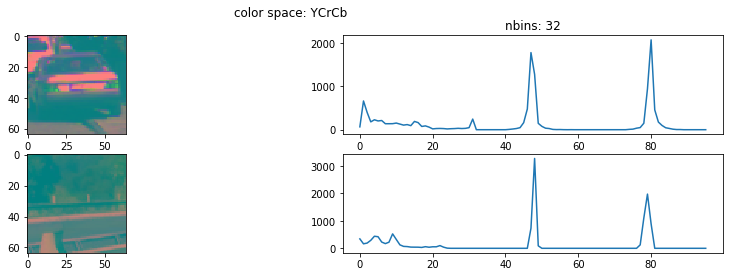

In [6]:
# let's look at 1 image with the default settings from each set using YCrCb
img_v = cv2.imread(cars[random.randrange(0,len(cars))])
img_v = img_v.astype(np.float32)/255
img_nv = cv2.imread(notcars[random.randrange(0,len(notcars))])
img_nv = img_nv.astype(np.float32)/255

img_pv = cv2.cvtColor(img_v, color_list['YCrCb'])
img_pnv = cv2.cvtColor(img_nv, color_list['YCrCb'])
feature_vec_v = fe.color_hist(img_pv)
feature_vec_nv = fe.color_hist(img_pnv)

# plot the images and the spatial bin results
fig, ax = plt.subplots(2,2,figsize=(15,4))
plt.suptitle("color space: {}".format('YCrCb'))
ax[0,0].imshow(img_pv)
ax[1,0].imshow(img_pnv)
ax[0,1].plot(feature_vec_v)
ax[0,1].set_title("nbins: {}".format('32'))
ax[1,1].plot(feature_vec_nv)

plt.show()

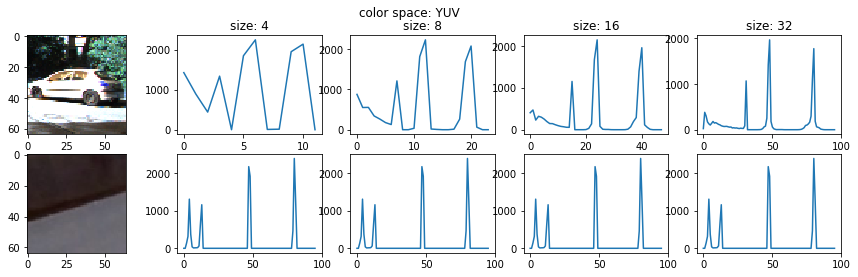

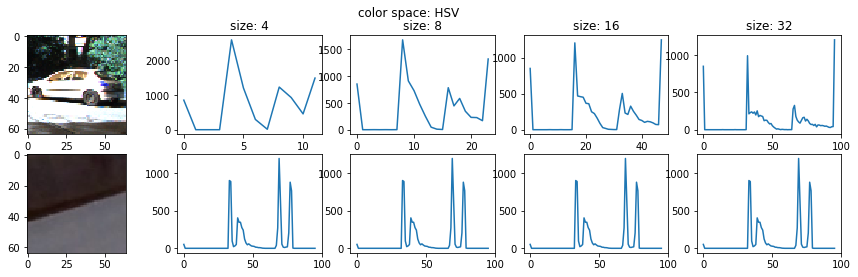

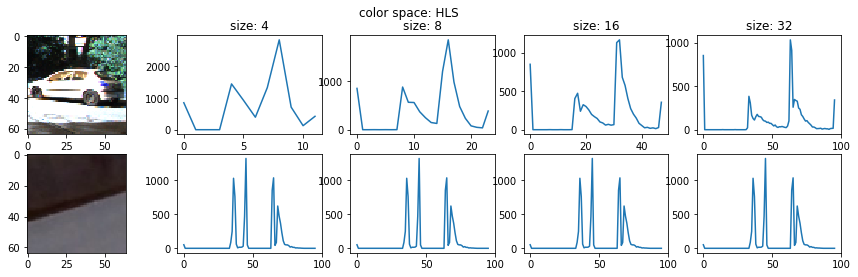

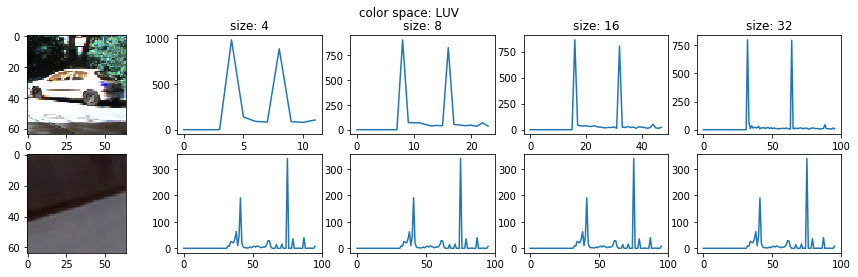

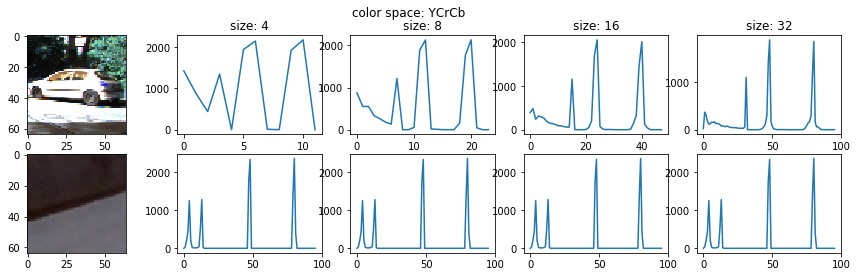

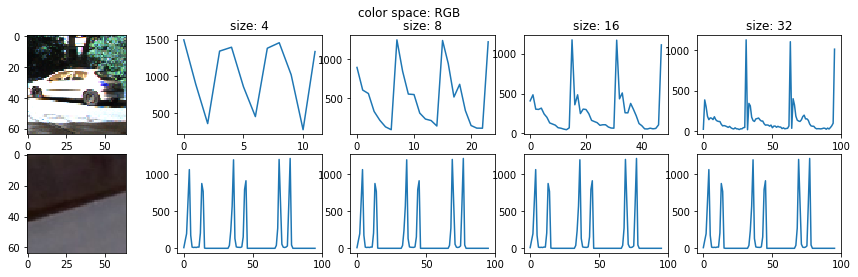

In [7]:
# select random vehicle and non-vehicle images and rescale to 0..1, will open as BGR
img_v = cv2.imread(cars[random.randrange(0,len(cars))])
img_v = img_v.astype(np.float32)/255
img_nv = cv2.imread(notcars[random.randrange(0,len(notcars))])
img_nv = img_nv.astype(np.float32)/255

# define the parameter list for bin ranges - the training data is 64x64
sizes = [4,8,16,32]

# cycle through the color_list and sizes list and show the various results...
for key in color_list:
    # create an output figure
    fig, ax = plt.subplots(2,len(sizes)+1,figsize=(15,4))
    plt.suptitle("color space: {}".format(key))
    c = 0
    # create an image copy for the color space
    img_pv = cv2.cvtColor(img_v, color_list[key])
    img_pnv = cv2.cvtColor(img_nv, color_list[key])
    ax[0,c].imshow(img_v)
    ax[1,c].imshow(img_nv)
    c += 1
    # cycle the sizes
    for size in sizes:
        feature_vec_v = fe.color_hist(img_pv, nbins=size)
        feature_vec_nv = fe.color_hist(img_pnv)
        ax[0,c].plot(feature_vec_v)
        ax[0,c].set_title("size: {}".format(size))
        ax[1,c].plot(feature_vec_nv)
        c += 1
plt.show()

## Explore Hog Features
The last technique is Histogram of Oriented Features. The write up will contain a fuller description of how this works. The tuning parameters for this function are the color space, the number of bins for the histograms (orientations), the pixels per cell and the cells per block

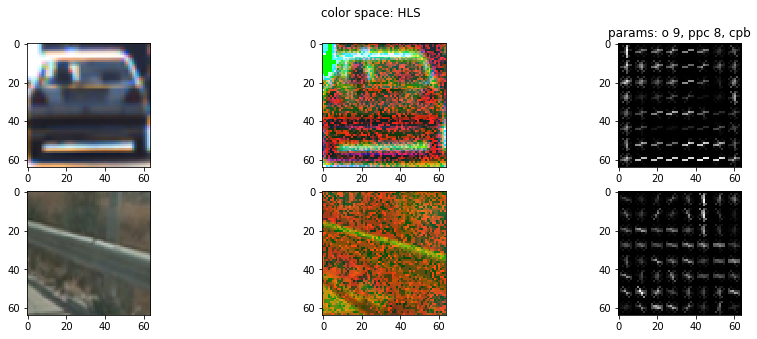

In [8]:
# let's look at 1 image with the default settings from each set using the H channel from HLS (:,:,0)
img_v = cv2.imread(cars[random.randrange(0,len(cars))])
img_v = img_v.astype(np.float32)/255
img_nv = cv2.imread(notcars[random.randrange(0,len(notcars))])
img_nv = img_nv.astype(np.float32)/255

img_v_rgb = cv2.cvtColor(img_v, color_list['RGB'])
img_nv_rgb = cv2.cvtColor(img_nv, color_list['RGB'])

img_pv = cv2.cvtColor(img_v, color_list['HLS'])
img_pnv = cv2.cvtColor(img_nv, color_list['HLS'])
feature_vec_v, hog_image_v = fe.get_hog_features(img_pv[:,:,0], vis=True, feature_vec=False)
img_v_r = exposure.rescale_intensity(hog_image_v, in_range=(0, 10))
feature_vec_nv, hog_image_v = fe.get_hog_features(img_pnv[:,:,0], vis=True, feature_vec=False)
img_nv_r = exposure.rescale_intensity(hog_image_v, in_range=(0, 10))

# plot the images and the spatial bin results
fig, ax = plt.subplots(2,3,figsize=(15, 5))
plt.suptitle("color space: {}".format('HLS'))
ax[0,0].imshow(img_v_rgb)
ax[1,0].imshow(img_nv_rgb)
ax[0,1].imshow(img_pv)
ax[1,1].imshow(img_pnv)
ax[0,2].imshow(img_v_r, cmap='gray')
ax[0,2].set_title("params: o {}, ppc {}, cpb".format(9, 8, 2))
ax[1,2].imshow(img_nv_r, cmap='gray')

plt.show()

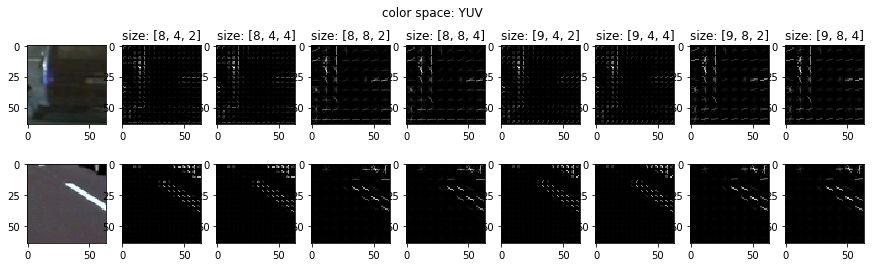

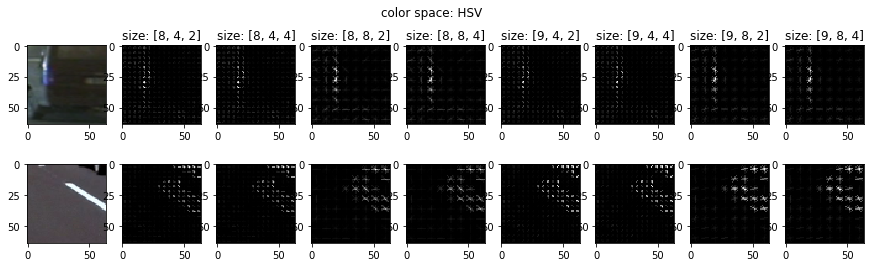

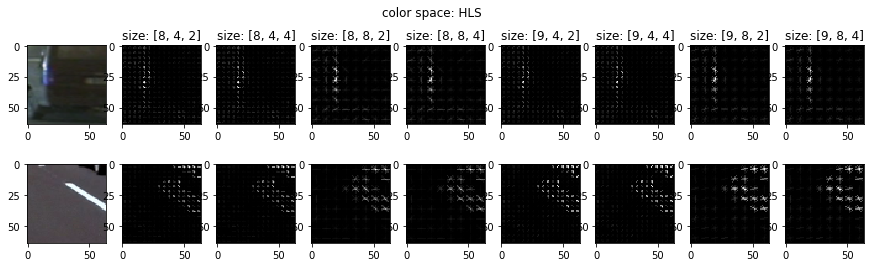

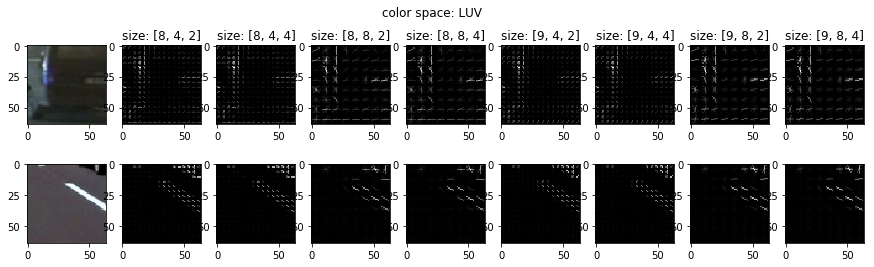

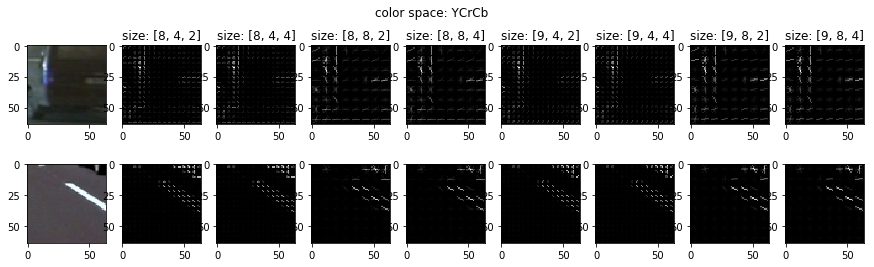

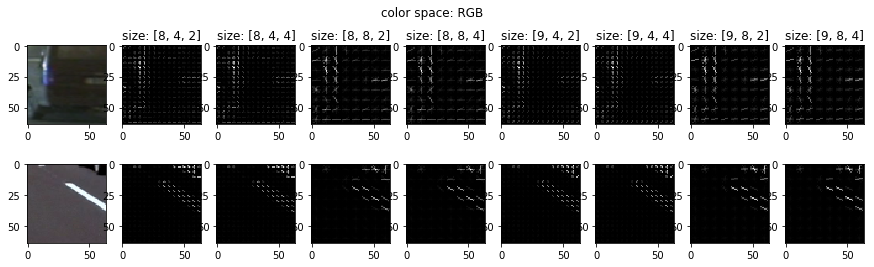

In [9]:
# select random vehicle and non-vehicle images and rescale to 0..1, will open as BGR
img_v = cv2.imread(cars[random.randrange(0,len(cars))])
img_v = img_v.astype(np.float32)/255
img_nv = cv2.imread(notcars[random.randrange(0,len(notcars))])
img_nv = img_nv.astype(np.float32)/255

# hog parameters: orientations, pixels per cell, cells per block
hog_list = [
    [8,9],
    [4,8],
    [2,4]
]

# create flattened list of hog tuning parameters
hog_params = [[x,y,z] for x in hog_list[0] for y in hog_list[1] for z in hog_list[2]]

for key in color_list:
    # create an output figure
    fig, ax = plt.subplots(2,len(hog_params)+1,figsize=(15,4))
    plt.suptitle("color space: {}".format(key))
    c = 0
    # create an image copy for the color space
    img_pv = cv2.cvtColor(img_v, color_list[key])
    img_pnv = cv2.cvtColor(img_nv, color_list[key])
    ax[0,c].imshow(img_v)
    ax[1,c].imshow(img_nv)
    c += 1
    # cycle the params
    for param in hog_params:
        feature_vec_v, hog_image_v = fe.get_hog_features(img_pv[:,:,0], orient=param[0], 
                        pix_per_cell=param[1], cell_per_block=param[2], 
                        vis=True, feature_vec=False)
        img_v_r = exposure.rescale_intensity(hog_image_v, in_range=(0, 10))
        feature_vec_nv, hog_image_nv = fe.get_hog_features(img_pnv[:,:,0], orient=param[0], 
                        pix_per_cell=param[1], cell_per_block=param[2], 
                        vis=True, feature_vec=False)
        img_nv_r = exposure.rescale_intensity(hog_image_nv, in_range=(0, 10))
        
        ax[0,c].imshow(img_v_r, cmap='gray')
        ax[0,c].set_title("size: {}".format(param))
        ax[1,c].imshow(img_nv_r, cmap='gray')
        c += 1
plt.show()

we'll now look at how many features we could end up with by running all the images through the feature extraction routine for cars and noncars with some nominal settings

In [16]:
# all possible features...
extraction_features = {
    'color_space': 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'orient': 9, 
    'pix_per_cell': 8, # HOG pixels per cell
    'cell_per_block': 2, # HOG cells per block
    'hog_channel': "ALL", # Can be 0, 1, 2, or "ALL"
    'spatial_size': (32, 32), # Spatial binning dimensions
    'hist_bins': 16, # Number of histogram bins
    'spatial_feat': True, # Spatial features on or off
    'hist_feat': True, # Histogram features on or off
    'hog_feat': True # HOG features on or off
}
 
t=time.time()
car_features = fe.extract_features(cars, cspace=extraction_features['color_space'], 
                        spatial_size=extraction_features['spatial_size'], hist_bins=extraction_features['hist_bins'], 
                        orient=extraction_features['orient'], pix_per_cell=extraction_features['pix_per_cell'], 
                        cell_per_block=extraction_features['cell_per_block'], 
                        hog_channel=extraction_features['hog_channel'], spatial_feat=extraction_features['spatial_feat'], 
                        hist_feat=extraction_features['hist_feat'], hog_feat=extraction_features['hog_feat'])
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract car features...')

notcar_features = fe.extract_features(notcars, cspace=extraction_features['color_space'], 
                        spatial_size=extraction_features['spatial_size'], hist_bins=extraction_features['hist_bins'], 
                        orient=extraction_features['orient'], pix_per_cell=extraction_features['pix_per_cell'], 
                        cell_per_block=extraction_features['cell_per_block'], 
                        hog_channel=extraction_features['hog_channel'], spatial_feat=extraction_features['spatial_feat'], 
                        hist_feat=extraction_features['hist_feat'], hog_feat=extraction_features['hog_feat'])

t3 = time.time()
print(round(t3-t2, 2), 'Seconds to extract non car features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

t4 = time.time()
print(round(t4-t, 2), 'Seconds to extract all features and map to X, y...')

print("this leaves us with {} features per image over {} total training images of which {} are cars".format(len(car_features[0]),
                                                                                                      len(X), 
                                                                                                      len(car_features)))

92.14 Seconds to extract car features...
74.56 Seconds to extract non car features...
170.49 Seconds to extract all features and map to X, y...
this leaves us with 8412 features per image over 17760 total training images of which 8792 are cars


In [17]:
# let's pickle the extraction parameters
filename = 'extraction_features.pkl'
output = open(filename, 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(extraction_features, output)

output.close()

# let's test this by reading and printing it
features_file = open(filename, 'rb')

features = pickle.load(features_file)
print(features)
features_file.close()

{'color_space': 'YCrCb', 'hog_channel': 'ALL', 'spatial_size': (32, 32), 'orient': 9, 'pix_per_cell': 8, 'spatial_feat': True, 'hist_feat': True, 'hog_feat': True, 'hist_bins': 16, 'cell_per_block': 2}


In [18]:
# let's save this data for use later

filename = 'data/training_data'
temp = open(filename, 'w+b')
try:
    np.savez(temp, X=X, y=y)
finally:
    temp.close()

In [19]:
temp = open(filename, 'r+b')
try:
    training_data = np.load(filename)
    training_data.files
finally:
    temp.close()

In [20]:
X1 = training_data['X']
len(X1[0])

8412